In [1]:
%run Natural_Environment_Model.ipynb
%run Aerodynamics_Model.ipynb
%run Display_Information.ipynb

/home/cory/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.engine.mdot if rkt.has_fuel() else 0
    F1 = dynamics(env, rkt, state, parameters)
    k1 = derivatives(state, [mdot, F1[3], rkt.moment, F1[0], F1[1], F1[2]])
    
    state_2 = [sum(pair) for pair in zip(state, dt[-1]*k1/2)]
    state_2[2] = normalize(state_2[2])
    F2 = dynamics(env, rkt, state_2, parameters)
    k2 = derivatives(state_2, [mdot, F2[3], rkt.moment, F2[0], F2[1], F2[2]])
    
    state_3 = [sum(pair) for pair in zip(state, dt[-1]*k2/2)]
    state_3[2] = normalize(state_3[2])
    F3 = dynamics(env, rkt, state_3, parameters)
    k3 = derivatives(state_3, [mdot, F3[3], rkt.moment, F3[0], F3[1], F3[2]])
    
    state_4 = [sum(pair) for pair in zip(state, dt[-1]*k3)]
    state_4[2] = normalize(state_4[2])
    F4 = dynamics(env, rkt, state_4, parameters)
    k4 = derivatives(state_4, [mdot, F4[3], rkt.moment, F4[0], F4[1], F4[2]])
    
    return [(k1 + 2*k2 + 2*k3 + k4) / 6,
            (F1 + 2*F2 + 2*F3 + F4) / 6,
            None]

# http://maths.cnam.fr/IMG/pdf/RungeKuttaFehlbergProof.pdf
def adaptive_runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.engine.mdot if rkt.has_fuel() else 0
    F1 = dynamics(env, rkt, state, parameters)
    k1 = derivatives(state, [mdot, F1[3], rkt.moment, F1[0], F1[1], F1[2]])
    
    state_2 = [sum(pair) for pair in
               zip(state, dt[-1]*k1/4)]
    state_2[2] = normalize(state_2[2])
    F2 = dynamics(env, rkt, state_2, parameters)
    k2 = derivatives(state_2, [mdot, F2[3], rkt.moment, F2[0], F2[1], F2[2]])
    
    state_3 = [sum(pair) for pair in
               zip(state, dt[-1] *(3*k1 + 9*k2)/32)]
    state_3[2] = normalize(state_3[2])
    F3 = dynamics(env, rkt, state_3, parameters)
    k3 = derivatives(state_3, [mdot, F3[3], rkt.moment, F3[0], F3[1], F3[2]])
    
    state_4 = [sum(pair) for pair in
               zip(state, dt[-1]*(1932*k1 - 7200*k2 + 7296*k3)/2197)]
    state_4[2] = normalize(state_4[2])
    F4 = dynamics(env, rkt, state_4, parameters)
    k4 = derivatives(state_4, [mdot, F4[3], rkt.moment, F4[0], F4[1], F4[2]])
    
    state_5 = [sum(pair) for pair in
               zip(state, dt[-1]*(439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))]
    state_5[2] = normalize(state_5[2])
    F5 = dynamics(env, rkt, state_5, parameters)
    k5 = derivatives(state_5, [mdot, F5[3], rkt.moment, F5[0], F5[1], F5[2]])
    
    state_6 = [sum(pair) for pair in
               zip(state, dt[-1]*(-8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))]
    state_6[2] = normalize(state_6[2])
    F6 = dynamics(env, rkt, state_6, parameters)
    k6 = derivatives(state_6, [mdot, F6[3], rkt.moment, F6[0], F6[1], F6[2]])
    
    order_5 = state + dt[-1] * (16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55)
    order_5[2] = normalize(order_5[2])
    return [25*k1/216 + 1408*k3/2565 + 2197*k4/4101 - k5/5,
            25*F1/216 + 1408*F3/2565 + 2197*F4/4101 - F5/5,
            order_5]

In [3]:
# state = [m, x, q, v, w], is it an issue that our CoM changes but we still use F=MA?
# parameters = [mdot, thtl, I_body, forces, torques], is it a sin to not update MoI as a state variable?
# reference (7.233) on page 435 of Shabana for dynamical equations
def derivatives(state, parameters):
    def dm_dt(mdot, throttle):
        return -mdot*throttle
    
    # kinematic equations of motion
    def dx_dt(v):
        return v
    
    def dq_dt(q, w):
        return 1/2 * product(q, np.array([0, w[0], w[1], w[2]]))
    
    # dynamical equations of motion
    def dv_dt(mass, forces, accels):
        return accels + forces / mass
    
    def dw_dt(J_body, w, torque):
        return np.linalg.inv(J_body).dot(torque - np.cross(w, J_body.dot(w)))
    
    return np.array([dm_dt(parameters[0], parameters[1]),
                     dx_dt(state[3]),
                     dq_dt(state[2], state[4]),
                     dv_dt(state[0], parameters[3], parameters[4]),
                     dw_dt(parameters[2], state[4], parameters[5])], dtype=object)
    
def dynamics(env, rkt, state, param):
    air, wind = env.atmo(state[1])
    if not rkt.wind_on:
        wind  = np.zeros(3)
    aero      = env.aero(state, rkt, air, wind)
    aero[0]  *= param[2]
    
    cor_acc   = env.coriolis(state[3])
    grav_acc  = env.g_accel(state[1])
    grav_torq = env.T_gg(state[1], state[2], rkt.moment)
    
    if not rkt.off_tower:
        g         = np.linalg.norm(grav_acc)
        direction = sandwich(state[2], [0,0,1])
        cor_acc   = -direction * g * np.cos(rkt.El) * 0.2 # this here is actually the friction acceleration
        grav_acc  = -direction * g * np.sin(rkt.El)
        grav_torq = np.zeros(3)
    
    # still need a better method for throttling than just drag limiting, low priority
    if rkt.has_fuel():
        throttle = rkt.engine.throttle_engine(np.linalg.norm(aero[0]))
        thrust   = rkt.engine.thrust(air[0], throttle) * rkt.engine.thrust_vector
    else:
        throttle = 0.
        thrust   = np.zeros(3)
    
    if not rkt.descending:
        forces = sandwich(state[2], sum([aero[0], thrust, param[0]])) # put forces in inertial frame
    else:
        forces = aero[0]
    
    accels = sum([grav_acc, cor_acc])
    torque = sum([grav_torq, aero[1], param[1]])
    return np.array([forces, accels, torque, throttle, air, aero, thrust], dtype=object)

In [4]:
def event_manager(new, update, env, rkt, state, dt, state_list):
    if (not rkt.off_tower and (np.linalg.norm(new[1] - state_list[0][0][1]) >= launch_tower) and
                              (np.linalg.norm(state[1] - state_list[0][0][1]) < launch_tower)):
        rkt.off_tower = True
        rkt.tower_index = len(state_list)
        
        avg_vel = np.sin(rkt.El) * np.linalg.norm(state[3])
        rkt.launch_speed = avg_vel
        T = 0
        
        if rkt.tip_off_error:
            acc = np.linalg.norm(update[0][3]) * np.sin(rkt.El)
            tipoff_time = max(np.roots([acc/2, avg_vel, -rkt.lug_separation]))
            g = np.linalg.norm(env.g_accel(state[1]))
            T = rkt.mass * rkt.lug_separation * g * np.sin(rkt.El)
            omega = T * tipoff_time / rkt.moment[1][1]
            alpha = omega * tipoff_time / 2
            #state[4][1] += omega
            #state[2] = product(state[2], eulerangle_to_quat(0, alpha, 0))
            #T = 0
        
        parameters = [np.zeros(3), np.array([0, T, 0]), rkt.drag_perturb]
        if rkt.adaptive:
            update = adaptive_runge_kutta(env, rkt, state, parameters, dt)
        else:
            update = runge_kutta(env, rkt, state, parameters, dt)
            #dt.append(dt[0])
        
        new = state + dt[-1] * update[0]
        new[2] = normalize(new[2])
        #print(alpha, omega, new[4])

        rkt.tip_off_aoa = np.degrees(update[1][5][5])   
        
    if not rkt.adaptive and len(state_list) == rkt.tower_index + 10:
        dt.append(dt[0])
        
    if (rkt.off_tower and not rkt.past_maxq and update[1][5][3] - state_list[-1][1][1][5][3] <= 0):
        rkt.past_maxq  = True
        rkt.maxq_index = len(state_list)
        rkt.maxq       = update[1][5][3]
        
    if not rkt.empty and not rkt.has_fuel():
        rkt.empty = True
        rkt.F_index = len(state_list) - 1 # -1 because we care about the last moment there was thrust
        
    if (not rkt.descending and np.dot(state[3], state[1]) > 0 
                           and np.dot(new[3], new[1]) <= 0):
        rkt.descending = True
        rkt.apogee = np.linalg.norm(new[1]) - env.initial_height
        rkt.ap_index = len(state_list)
        
    return new, update    
    
def time_step(env, rkt, state, dt, state_list):
    if rcs_control and rkt.off_tower:
        num_thrusters, rcs_force, rcs_torque = rkt.rcs.controller(state[2], state_list[-1][1][1][4][0], rkt.CoM)
    else:
        num_thrusters, rcs_force, rcs_torque = 0, np.zeros(3), np.zeros(3)
        
    # may even want this up one more step in the hierarchy
    parameters = [rcs_force, rcs_torque, rkt.drag_perturb]
    
    if rkt.adaptive:
        update = adaptive_runge_kutta(env, rkt, state, parameters, dt)
    else:
        update = runge_kutta(env, rkt, state, parameters, dt)
        
    new = state + dt[-1] * update[0]
    new[2] = normalize(new[2])
    stability_margin = (rkt.CoM[2] - update[1][5][6]) / rkt.diameter
    
    if not rkt.descending:
        rkt.rcs.parts[0].drain(num_thrusters*rkt.rcs.mdot * dt[-1])
        rkt.rcs.parts[1].exhaust_velocity(rkt.rcs.pressure())

        if not rkt.empty:
            del_m_o, del_m_f = proportion(dt[-1]*update[0][0], rkt.OF)
            rkt.lox_tank.drain(del_m_o)
            rkt.ipa_tank.drain(del_m_f)

        rkt.sum_parts()
    
    # for openrocket engine
    m_prop = rkt.lox_tank.parts[-1].mass + rkt.ipa_tank.parts[-1].mass
    openrocket_CoM = rkt.eng_sys.CoM[2]
    
    new, update = event_manager(new, update, env, rkt, state, dt, state_list)
    
    if rkt.adaptive and len(state_list) > rkt.tower_index + 10:
        diff = 2 * sqrt(sum([np.linalg.norm(i)**2 for i in (update[-1] - new)]))
        rkt.error.append(diff/2)
        if diff == 0: diff = 0.01
        dt.append(dt[-1] * (rkt.tol/diff)**.25)
    
     
    state_list.append((new, update[:-1], stability_margin, m_prop, openrocket_CoM))

def still_running(state_list, rkt, env, descend):
    velocity_condition = not descend and not rkt.descending
    position_condition = descend and env.ECEF_to_geodetic(state_list[-1][0][1])[2] > launch_site_alt
    return velocity_condition or position_condition

def integration(env, rkt, azimuth, elevation, dt, descend):
    stop = False
    env.first_time_env = True
    rkt.empty = False
    rkt.off_tower = False
    rkt.past_maxq = False
    rkt.descending = False
    rkt.error = []
    state_list = []
    rkt.dt = [dt, 0.025]
    rkt.F_index = 0
    rkt.tower_index = 9999
    rkt.ap_index = 0
    rkt.El = np.radians(elevation)
    launcher_attitude  = eulerangle_to_quat(np.pi - np.radians(azimuth), np.pi/2 - np.radians(elevation), 0)
    initial_attitude   = product(env.initial_orientation, launcher_attitude)
    initial_state = np.array([rkt.mass, env.initial_position + sandwich(initial_attitude, rkt.CoM),
                              initial_attitude, np.zeros(3), np.zeros(3)], dtype=object)
    state_list.append((initial_state, 0)) # kludge, at some point clean initialization up. low priority
    
    time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
    while still_running(state_list, rkt, env, descend):
        time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
    
    return state_list

In [5]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter)

def trajectory(m_prop, mdot, p_e,
               throttle_window, min_throttle,
               rcs_mdot, rcs_p_e, rcs_p_ch,
               ballast, root, tip, sweep, span, thickness,
               airfrm_in_rad, OF, p_ch, T_ch, ke, MM, perturbations,
               dt, adaptive=False, tol=0.042, descend=False, early_return=False):
    
    LV4 = create_rocket(m_prop, mdot, p_e,
                    p_ch, T_ch, ke, MM,
                    throttle_window, min_throttle,
                    airfrm_in_rad, OF,
                    rcs_mdot, rcs_p_e, rcs_p_ch,
                    ballast, root, tip, sweep, span, thickness)
    aero_model = AeroModel(LV4.diameter, LV4.length, nose_l,
                           LV4.fin)
    LV4.adaptive = adaptive
    LV4.tol = tol
    
    env = Environment(aero_model, 17.7, launch_site_loc[0] + perturbations[0], launch_site_loc[1] + perturbations[1])
    LV4.tip_off_error = perturbations[4]
    LV4.wind_on       = perturbations[11]
    # doing engine perturbations after creating engine so mimic reduced performance for identical geometries
    LV4.engine.thrust_vector = sandwich(eulerangle_to_quat(0, np.radians(perturbations[5]), np.radians(perturbations[6])), [0,0,1])
    LV4.engine.mdot += perturbations[7]
    LV4.engine.p_e += perturbations[8]
    LV4.engine.exhaust_velocity(LV4.engine.p_ch)
    LV4.parts[-1].add_part(LV4.CoM, 'Weight Perturbation', perturbations[9], 0.1, 0, 0, 'Point')
    LV4.sum_parts()
    LV4.drag_perturb += perturbations[10]
    states = integration(env, LV4, 0 + perturbations[2], 89 + perturbations[3], dt, descend)
    
    sim = SimpleNamespace()
    sim.raw_states = states
    sim.LV4 = LV4
    sim.env = env
    sim.perturbations = perturbations
    sim.launch_speed = LV4.launch_speed
    sim.apogee = LV4.apogee
    sim.ap_index = LV4.ap_index - 1
    sim.tower_index = LV4.tower_index - 1
    sim.F_index = LV4.F_index - 1 # subtract one cus we're throwing away the first entry. pardon the kludge
    sim.impact = np.array(env.ECEF_to_geodetic(sim.raw_states[-1][0][1])[:2])
    if early_return: return sim
    
    sim.alt = []
    sim.v = []
    sim.a = []
    sim.thrust = []
    sim.drag = []
    sim.dyn_press = []
    sim.p_a = []
    sim.rho = []
    sim.t = []
    sim.Ma = []
    sim.m = []
    sim.throttle = []
    sim.stability_margin = []
    sim.m_prop = []
    sim.openrocket_CoM = []
    sim.fin_flutter = []
    
    for i, state in enumerate(states[1:]):
        r = np.linalg.norm(state[0][1])
        sim.alt.append(r - env.initial_height)
        sim.v.append(np.dot(state[0][1], state[0][3]) / r)
        sim.a.append(np.dot(state[0][1], state[1][0][3]) / r)
        sim.thrust.append(state[1][1][6])
        sim.drag.append(abs(state[1][1][5][0][2]))
        sim.dyn_press.append(state[1][1][5][3])
        sim.fin_flutter.append(state[1][1][5][7] / sim.v[-1])
        sim.p_a.append(state[1][1][4][0])
        sim.rho.append(state[1][1][4][1])
        sim.t.append(i*dt) # kludge? add time as a state variable, low priority
        sim.Ma.append(state[1][1][5][4])
        sim.m.append(state[0][0])
        sim.throttle.append(state[1][1][3])
        sim.stability_margin.append(state[2])
        sim.m_prop.append(state[3])
        sim.openrocket_CoM.append(state[4])
    
    sim.alt = np.array(sim.alt)
    sim.v = np.array(sim.v)
    sim.a = np.array(sim.a)
    sim.thrust = np.array(sim.thrust)
    sim.drag = np.array(sim.drag)
    sim.dyn_press = np.array(sim.dyn_press)
    sim.p_a = np.array(sim.p_a)
    sim.rho = np.array(sim.rho)
    sim.t = np.array(sim.t)
    sim.fin_flutter = np.array(sim.fin_flutter)
    
    # note g_n is a global constant in inputs
    # this will run after we reach apogee to do last-minute calculations and conversions
    sim.TWR = sim.a[0] / g_n                  # Thrust-to-weight ratio constraint
    sim.S_crit = LV4.engine.p_e / sim.p_a[0]         # Sommerfield criterion constraint
    sim.massratio = LV4.GLOW / sim.m[-1] # Mass ratio
    sim.dV1 = LV4.engine.Ve * np.log(sim.massratio) / 1000            # Tsiolkovsky's bane (delta-V)
    sim.max_g_force = max([np.linalg.norm(state[1][0][3]) for state in states[1:]]) / g_n   # calculates top g-force
    sim.maxq = max(sim.dyn_press)
    # ignoring the end of flight stability cuz it doesn't really matter
    sim.min_stability = min(sim.stability_margin[:sim.F_index])
    sim.min_fin_flutter = min(sim.fin_flutter[:sim.F_index])
    sim.ld_ratio = sim.LV4.length / sim.LV4.diameter
    
    return sim

In [6]:
#%%timeit -n 1 -r 1 pass
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    test_run = trajectory(144.589, 2.871, 74610.004, throttle_window, min_throttle, rcs_mdot, rcs_p_e, rcs_p_ch, 
                          ballast, root, tip, sweep, span, thickness, airfrm_in_rad,
                          OF, p_ch, T_ch, ke, MM,
                          [0, 0, 0, 0, True, 0, 0, 0, 0, 0, 0, False], 
                          0.05, True, 0.045, True)

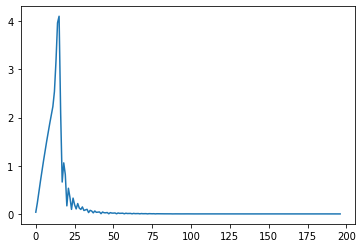

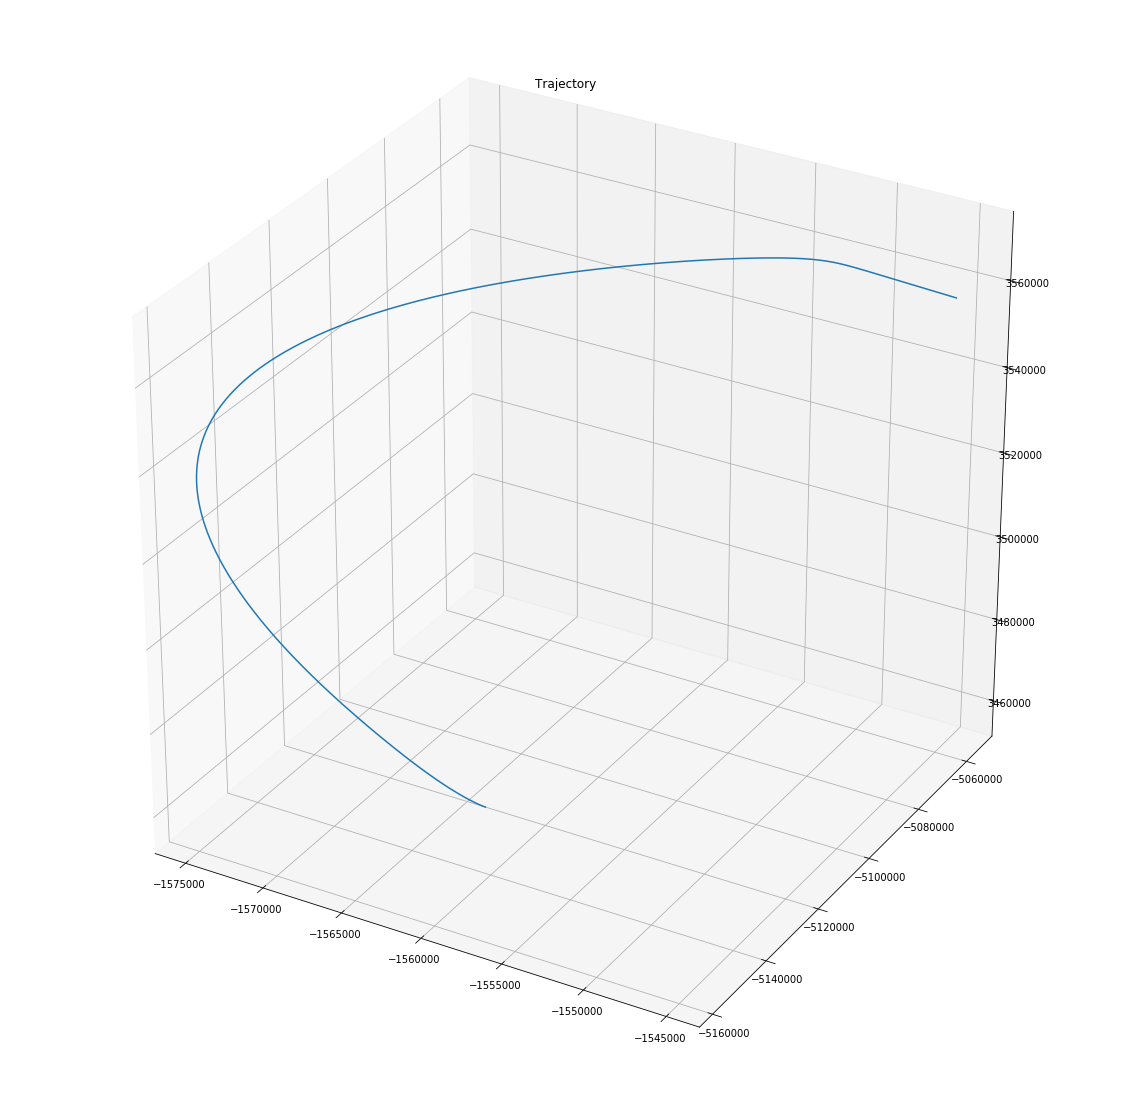

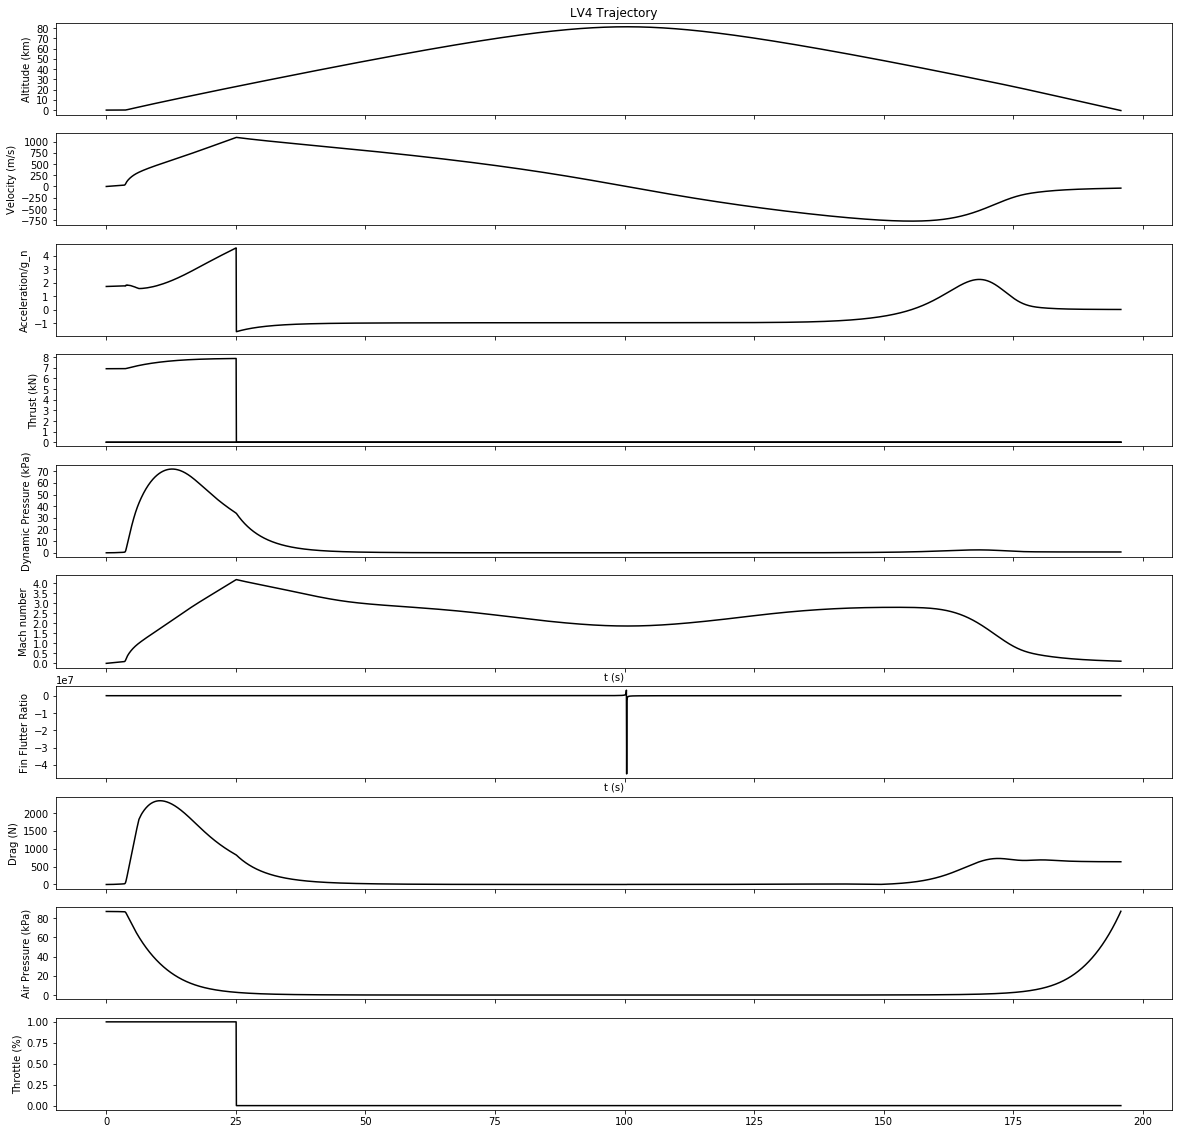

(34.11314113474378, -106.99203422219539, 1352.1621888858351)
81178.87771840673
4.1016965209627045
0.03594601545527525

DESIGN VECTOR

-----------------------------

design total propellant mass               = 144.517 kg

design mass flow rate                      = 2.871 kg/s

design nozzle exit pressure                = 74610.004 Pa

total tankage length (after adjustment)    = 2.196 m

design airframe diameter                   = 0.321 m.

design airframe total length               = 6.231 m.

design GLOW                                = 259.274 kg

design ballast mass                        = 0.500 kg

design fin root chord                      = 0.700 m

design fin tip chord                       = 0.450 m

design fin sweep angle                     = 70.000 deg

design fin span                            = 0.420 m

design fin thickness                       = 3.175 mm



CONSTRAINTS

-----------------------------

Tip-Off angle of attack (c.f. < 15)         = 0.036 deg

L/D ratio

In [7]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter, CN, CDax)

# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    #from matplotlib import pyplot as plt

    fig, ax1 = plt.subplots()
    #ax1.plot(test_run.LV4.dt[:])
    #ax1.plot(test_run.LV4.error)
    #axs.plot(test.w) # test.LV4.length-
    ax1.plot([state[1][1][5][5]*180/np.pi
              for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.maxq_index]])
    #ax1.plot([np.linalg.norm(state[0][1]) - np.linalg.norm(test_run.raw_states[0][0][1]) for state in test_run.raw_states[1:]])
    #ax1.yaxis.major.locator.set_params(nbins=20)
    #ax1.plot(#test_run.Ma[1:test_run.F_index], [test_run.LV4.length - state[1][1][5][6] for state in test_run.raw_states[1:test_run.F_index]], '-r',
    #         test_run.Ma[1:test_run.F_index], [state[1][1][5][8] for state in test_run.raw_states[1:test_run.F_index]], '-b',label='CN')
    #ax1.plot(test_run.Ma[1:test_run.F_index], [state[1][1][5][9] for state in test_run.raw_states[1:test_run.F_index]], '-g', label='CD_axial')
    #ax1.legend()
    #         [state[0][1][2] for state in test_run.raw_states[1:]])
    plt.show()
    #print(max([test.LV4.length- state[2][3][6] for state in test.states[1:]]))
    #print(min([test.LV4.length- state[2][3][6] for state in test.states[1:2000]]))
    #print(test.LV4.length)
    
    rocket_plot(test_run.t, test_run.alt, test_run.v, test_run.a, test_run.thrust, test_run.dyn_press,
                test_run.Ma, test_run.m, test_run.p_a, test_run.drag, test_run.throttle, test_run.fin_flutter,
                test_run, False, None, None)
    
    print(test_run.env.ECEF_to_geodetic(test_run.raw_states[-1][0][1]))
    print(test_run.apogee)
    print(max([state[1][1][5][5]*180/np.pi
       for state in test_run.raw_states[test_run.LV4.tower_index:test_run.LV4.ap_index]]))
    print(test_run.LV4.tip_off_aoa)
    textlist = print_results(test_run, False)
    for line in textlist:
        print(line)